# GPcounts applied to scRNA-Seq time series data

Nuha BinTayyash, 2020

GPcounts is a Gaussian process regression package for counts data with negative binomial and zero-inflated negative binomial likelihoods as described in the paper "Non-parametric modelling of temporal and spatial counts data from RNA-seq experiments".


This notebook shows how to fit GPcounts with zero-inflated negative binomial, negative binomial and Gaussian likelihoods using full inference on ScRNA-seq gene expression data in Islet $\alpha$ cell from [GSE8737 single cell RNA-seq ](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE87375) dataset to find differentially expressed genes using infer trajectory and compare it with GPcounts with sparse inferece to obtain to obtain computational efficiency.

In [1]:
import pandas as pd
import numpy as np
import random
import gpflow 
from IPython.display import display

Load $\alpha$ gene expression data and pseudotime information

In [2]:
Y = pd.read_csv('../data/normalized_alpha_counts.csv',index_col=[0])
X = pd.read_csv('../data/alpha_time_points.csv',index_col=[0])
X.shape

(328, 1)

In [3]:
from GPcounts.GPcounts_Module import Fit_GPcounts
from helper import plot 

In [4]:
Y = Y.rename( index={'ENSMUSG00000015879': 'Fam184b','ENSMUSG00000059173':'Pde1a'})
genes_name = ['Fam184b','Pde1a']
Y.loc[genes_name]

,aE17.5_2_09,aE17.5_2_16,aE17.5_1_11,aE17.5_3_07,aE17.5_4_06,aE17.5_3_04,aE17.5_2_11,aE17.5_1_25,aE17.5_4_01,aE17.5_4_03,...,aP18_3_12,aP60_1_11,aP60_3_05,aP15_1_15,aP60_1_13,aP60_3_08,aP60_5_16,aP18_1_17,aP60_1_10,aP60_5_05
Fam184b,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,47.446494,0.0,0.0,0.0,0.0
Pde1a,53.19138,33.888555,0.0,63.941424,60.599705,40.608317,15.368216,23.786486,3.812432,44.32606,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Probabilty of zeros in Fam184b and Pde1a genes

In [5]:
Y.loc[genes_name][Y.loc[genes_name] == 0].count(axis=1)/len(Y.columns)

Fam184b    0.859756
Pde1a      0.628049
dtype: float64

## 1. Fit GPcounts with negative binomial likelihood assuming full inference on Fam184b and Pde1a genes

In [6]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],safe_mode = True) 
likelihood =  'Negative_binomial'

100%|██████████| 2/2 [00:13<00:00,  6.78s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-385.423242,-385.959712,0.536470
Pde1a,-797.367045,-807.318248,9.951203


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.8186780148045587
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.1410824344022714
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,32.89424608196025
VGP.likelihood.scale,Parameter,,,False,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(328, 1)",float64,[[-2.59189871e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[8.32531382e-01, 0.00000000e+00, 0.00000000e+00..."


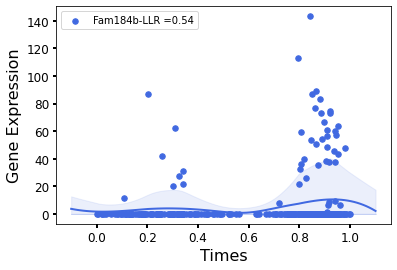

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.7226775923180533
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.324348221508195
VGP.likelihood.scale,Parameter,,,False,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(328, 1)",float64,[[9.86488610e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[1.63758132e-01, 0.00000000e+00, 0.00000000e+00..."


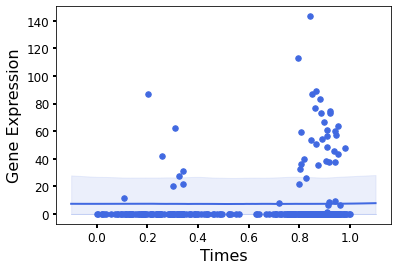

Pde1a


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.183566438252054
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7696437970669783
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.399886267248663
VGP.likelihood.scale,Parameter,,,False,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(328, 1)",float64,[[1.27557650e+00...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[1.93535557e-01, 0.00000000e+00, 0.00000000e+00..."


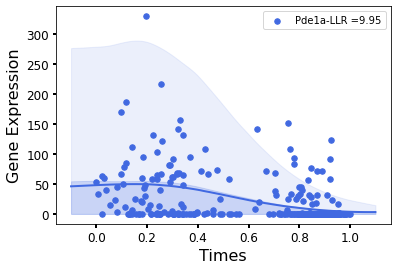

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.731413127206427
VGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,11.93889081845713
VGP.likelihood.scale,Parameter,,,False,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(328, 1)",float64,[[9.97611578e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 328, 328)",float64,"[[[6.41775345e-02, 0.00000000e+00, 0.00000000e+00..."


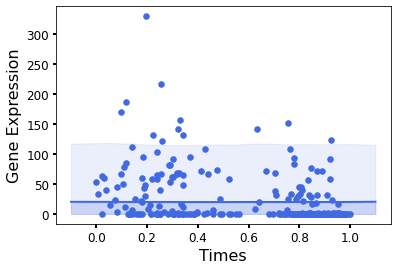

In [7]:
test_name = 'One_sample_test' # name of the test


results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)

plot(params,X.values,Y.loc[genes_name],results)


## 2. Fit GPcounts with negative binomial likelihood assuming sparse inference to obtain computational efficiency  on Fam184b and Pde1a genes

GPcounts by defaults use $5\%(N^*)$ to set the number of inducing points $M$ and [ $\epsilon- approximate\quad M-DPP$ algorithm](https://github.com/markvdw/RobustGP) to set the location of inducing points $Z$

$^* N = length(X)$

100%|██████████| 2/2 [00:07<00:00,  3.56s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-385.423247,-385.959709,0.536462
Pde1a,-797.366947,-807.318240,9.951293


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.820294454112077
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.14103802128495696
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,32.88947544894336
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[3.86833859e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[5.54705445e-01, 0.00000000e+00, 0.00000000e+00..."


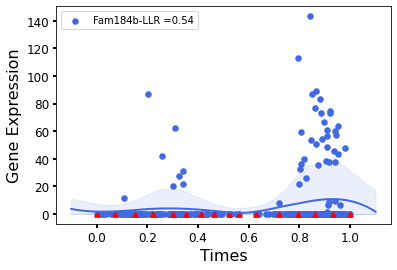

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.722771623840931
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.32479488323072
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[9.86467580e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[1.63758101e-01, 0.00000000e+00, 0.00000000e+00..."


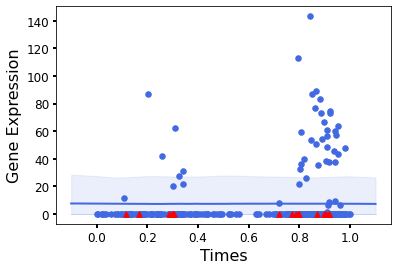

Pde1a


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.036853837484564
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.766130719333926
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.398632463190738
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[9.29761857e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[8.55673335e-02, 0.00000000e+00, 0.00000000e+00..."


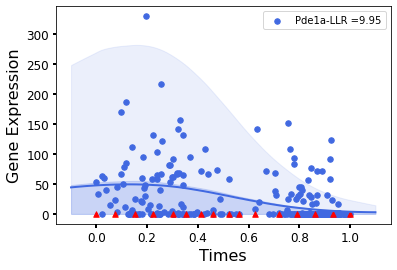

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.725946227022561
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,11.939130823045273
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(16, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[9.97939492e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[6.42114870e-02, 0.00000000e+00, 0.00000000e+00..."


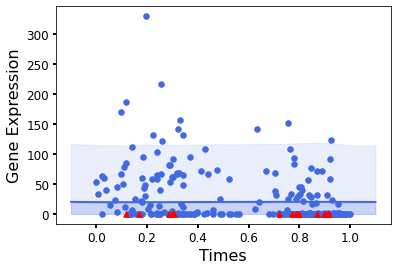

In [8]:
sparse = True 
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],sparse = sparse,safe_mode = True) # use sparse inference

results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results,sparse)

To set the number of inducing points $M = 4$ and use 𝜖−𝑎𝑝𝑝𝑟𝑜𝑥𝑖𝑚𝑎𝑡𝑒𝑀−𝐷𝑃𝑃 algorithm to set the location of inducing points  𝑍

100%|██████████| 2/2 [00:05<00:00,  2.89s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-385.475997,-385.959710,0.483713
Pde1a,-797.368310,-807.318243,9.949933


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.3394921611657704
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.1324257600577736
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,34.44306510477868
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(4, 1)",float64,[[1.05503849...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[-0.17987643, 0., 0...."


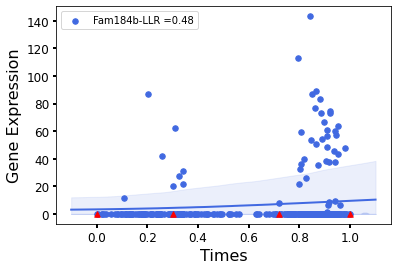

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.722749508386785
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.32433580133877
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(4, 1)",float64,[[9.86491511e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[1.63755213e-01, 0.00000000e+00, 0.00000000e+00..."


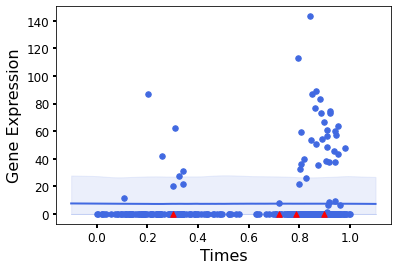

Pde1a


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.063085472047671
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7707499395071855
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.398932119285126
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(4, 1)",float64,[[0.92771357...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[0.08525904, 0., 0...."


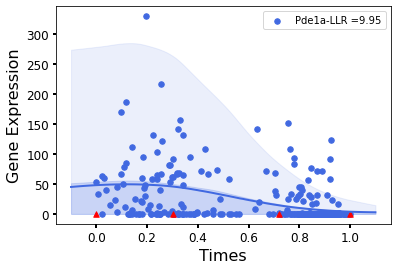

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.72414111514838
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,11.940704760714066
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(4, 1)",float64,[[0.71943149...
SVGP.q_mu,Parameter,,,True,"(4, 1)",float64,[[9.98043250e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 4, 4)",float64,"[[[6.42292056e-02, 0.00000000e+00, 0.00000000e+00..."


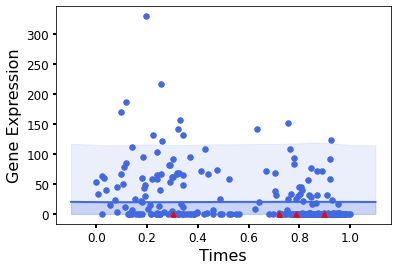

In [9]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],M = 4, sparse = sparse,safe_mode = True) # use sparse inference

results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results,sparse)

To use k-mean algorithm to set the location of inducing points 𝑍

$^*$ GPcounts by defaults use $5\%(N^*)$ to set the number of inducing points $M$ if M not specified

100%|██████████| 2/2 [00:06<00:00,  3.32s/it]

The results for Negative_binomial likelihood:


,Dynamic_model_log_likelihood,Constant_model_log_likelihood,log_likelihood_ratio
Fam184b,-385.560905,-385.959709,0.398804
Pde1a,-797.366993,-807.318240,9.951248


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

Fam184b


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,5.598889801848669
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.7579679933939585
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,34.10903193145507
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(16, 1)",float64,[[-1.08776744...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[-0.07544431...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[-6.42727306e-01, 0.00000000e+00, 0.00000000e+00..."


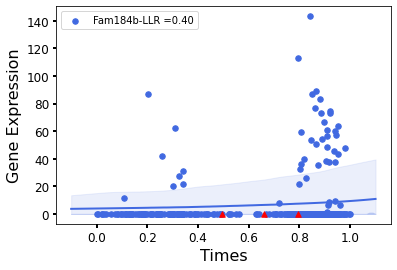

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.722564084489659
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,35.32432715303336
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(16, 1)",float64,[[0.02483172...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[9.86503013e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[1.63756314e-01, 0.00000000e+00, 0.00000000e+00..."


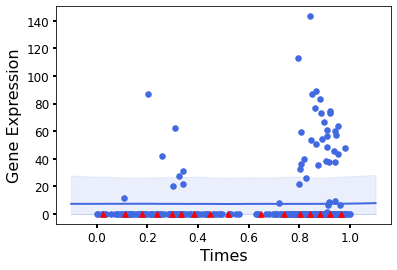

Pde1a


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.042303982185096
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7681453801427326
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,10.397436732735715
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,True,"(16, 1)",float64,[[0.67429351...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[9.99584776e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[9.25948996e-02, 0.00000000e+00, 0.00000000e+00..."


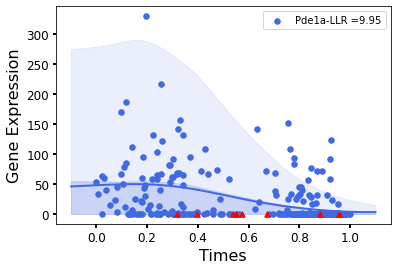

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,8.727673078994366
SVGP.likelihood.alpha,Parameter,Softplus,,True,(),float64,11.939217908138293
SVGP.likelihood.scale,Parameter,,,False,(),float64,1.0
SVGP.inducing_variable.Z,Parameter,,,False,"(16, 1)",float64,[[0.02483172...
SVGP.q_mu,Parameter,,,True,"(16, 1)",float64,[[9.97838609e-01...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 16, 16)",float64,"[[[6.42018945e-02, 0.00000000e+00, 0.00000000e+00..."


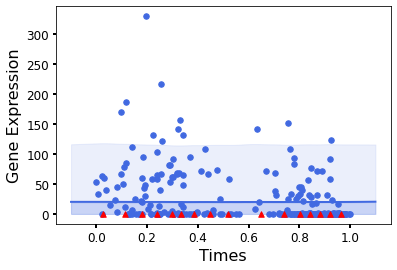

In [10]:
gp_counts = Fit_GPcounts(X,Y.loc[genes_name],sparse = sparse,safe_mode = True) # use sparse inference
gp_counts.kmean_algorithm_inducing_points( M = 16)

results = gp_counts.One_sample_test(likelihood)
print('The results for '+likelihood+' likelihood:')
display(results)
params = gp_counts.load_predict_models(genes_name,test_name,likelihood)
plot(params,X.values,Y.loc[genes_name],results,sparse)